# **DoorDash Machine Learning Data Science Take Home Assignment**

**Author: Emmanuel Acheampong**

**Date: 11/14/2021**

Due to the competitive landscape of the delivery app market, the ability to provide a fairly accurate estimation of delivery is essential to the business of DoorDash to be competitive. 

In this project. I'll be leveraging historical data to help predict the total delivery duration seconds it will take for a consumer's order to be delivered to them which will in turn help keep DoorDash maintain or improve it's bottom line. 

<br>
<br>
This notebook was built in Google Colab

https://colab.research.google.com/drive/1um6PTa7W6pX-RmRn_uNtPfFvgvZp7S3i?usp=sharing

<br>
<br>

*NB: Work done for this project uses work from Will Koehrsen' github repo on random_forests*


*Sources: https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained*

<img src="https://www.supermarketnews.com/sites/supermarketnews.com/files/styles/article_featured_retina/public/DoorDash-online%20grocery%20delivery-Dasher_0_0.jpg?itok=U_saeazE" />

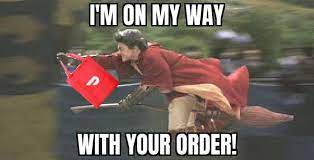
<img src="https://media4.giphy.com/media/VzkCRACE2PRdoJRx9c/200.gif" />



# **Importing necessary models**

In [ ]:
# importing necessary python modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import joblib

# **Data Acqusition**

In [ ]:
# Connecting to the google drive for data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
doorDash_ds = pd.read_csv("/content/drive/MyDrive/DoorDash/historical_data.csv")
doorDash_ds.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


# **Exploratory Data Analysis**

In [ ]:
print('The shape of the features of the dataset is:', doorDash_ds.shape)

The shape of the features of the dataset is: (197428, 9)


In [ ]:
doorDash_ds.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,196902.000000
mean,2.978706,3530.510272,2682.331402,44.808093,41.739747,58.050065,545.358935
std,1.524867,2053.496711,1823.093688,34.526783,32.145733,52.661830,219.352902
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000
25%,2.000000,1686.000000,1400.000000,17.000000,15.000000,17.000000,382.000000
50%,3.000000,3592.000000,2200.000000,37.000000,34.000000,41.000000,544.000000
75%,4.000000,5299.000000,3395.000000,65.000000,62.000000,85.000000,702.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000


In [ ]:
doorDash_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

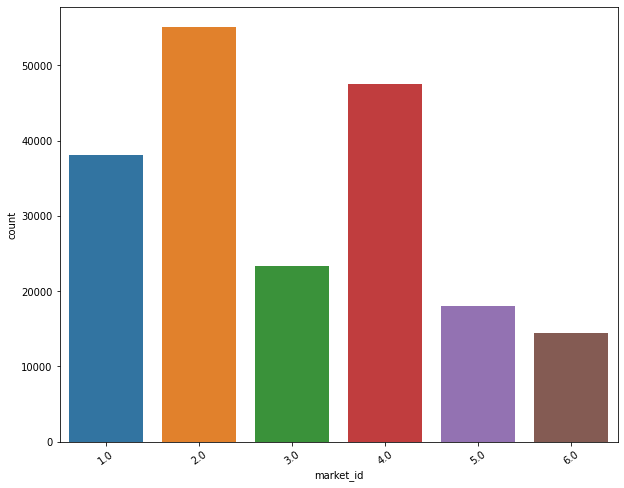

In [ ]:
doorDash_ds_cat = doorDash_ds["market_id"].value_counts().to_frame().reset_index()
doorDash_ds_cat.columns = ["market_id","count"]
plt.figure(figsize = (10,8))
sns.barplot(doorDash_ds_cat["market_id"],doorDash_ds_cat["count"])
plt.xticks(rotation=35)
#plt.figure(figsize = (10,8))

# **Data Pre-Processing**



In [ ]:
#Removing all null rows
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]
#
clean_dataset(doorDash_ds).head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [ ]:
# Add new column for delivery time 
doorDash_ds["delivery_time_in_seconds"]=(pd.to_datetime(pd.Series(doorDash_ds.actual_delivery_time)) - pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.total_seconds()

# Create new columns for day, year, month of created time, to potetially make datetime a feature in the model
doorDash_ds["available_dashers"]=doorDash_ds["total_onshift_dashers"] - doorDash_ds["total_busy_dashers"]
doorDash_ds["day"] = (pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.dayofweek
doorDash_ds["year"] = (pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.year
doorDash_ds["month"] = (pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.month
doorDash_ds["hour"] = (pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.hour
doorDash_ds["minute"] = (pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.minute
doorDash_ds["second"] = (pd.to_datetime(pd.Series(doorDash_ds.created_at))).dt.second


# Select columns for baseline features
doorDash_ds_baseline = doorDash_ds [["market_id","store_id","total_onshift_dashers", "total_busy_dashers", "subtotal","total_outstanding_orders", "estimated_store_to_consumer_driving_duration","delivery_time_in_seconds"]]

In [ ]:
# Removing all outliers in the data
z_scores = stats.zscore(doorDash_ds_baseline)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores<3).all(axis=1)
doorDash_ds_baseline = doorDash_ds_baseline[filtered_entries]

# **Baseline Features for model**



In [ ]:
# One-hot encode categorical features (not really ne)
doorDash_ds_baseline = pd.get_dummies(doorDash_ds_baseline)
doorDash_ds_baseline.head(5)

,market_id,store_id,total_onshift_dashers,total_busy_dashers,subtotal,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time_in_seconds
0,1.0,1845,33.0,14.0,3441,21.0,861.0,3779.0
1,2.0,5477,1.0,2.0,1900,2.0,690.0,4024.0
2,3.0,5477,1.0,0.0,1900,0.0,690.0,1781.0
3,3.0,5477,1.0,1.0,6900,2.0,289.0,3075.0
4,3.0,5477,6.0,6.0,3900,9.0,650.0,2390.0


In [ ]:
#labels and features
doorDash_ds_baseline_features = np.array(doorDash_ds_baseline.iloc[:, 0:-1])
doorDash_ds_baseline_labels = np.array(doorDash_ds_baseline.iloc[:, -1])

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(doorDash_ds_baseline_features, doorDash_ds_baseline_labels, test_size = 0.2,
                                                                           random_state = 45)

In [ ]:
print('Baseline Training Features Shape:', train_features.shape)
print('Baseline Training Labels Shape:', train_labels.shape)
print('Baseline Testing Features Shape:', test_features.shape)
print('Baseline Testing Labels Shape:', test_labels.shape)

Baseline Training Features Shape: (138794, 7)
Baseline Training Labels Shape: (138794,)
Baseline Testing Features Shape: (34699, 7)
Baseline Testing Labels Shape: (34699,)


In [ ]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, -2]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'seconds.')

Average baseline error:  2748.97 seconds.


# **Training Baseline Model**

In [ ]:
# Instantiate model 
rf = RandomForestRegressor(n_estimators= 200, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'seconds.')

Mean Absolute Error: 665.01 seconds.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 74.12 %.


In [ ]:
np.mean(mape)

25.8771348668072

# **Feature Selection: Training Model with only more features**

In [ ]:

rf_new = RandomForestRegressor(n_estimators = 200, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(doorDash_ds_baseline.iloc[:, 0:-1].columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: estimated_store_to_consumer_driving_duration Importance: 0.21
Variable: subtotal             Importance: 0.18
Variable: total_outstanding_orders Importance: 0.18
Variable: store_id             Importance: 0.15
Variable: total_onshift_dashers Importance: 0.14
Variable: total_busy_dashers   Importance: 0.09
Variable: market_id            Importance: 0.05


In [ ]:
doorDash_ds_baseline_updated = doorDash_ds [["market_id","store_id","month","day","hour","minute","second","total_onshift_dashers", "total_busy_dashers","available_dashers", "subtotal","total_outstanding_orders", "estimated_store_to_consumer_driving_duration","delivery_time_in_seconds"]]

# Removing all outliers
z_scores = stats.zscore(doorDash_ds_baseline_updated)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores<3).all(axis=1)
doorDash_ds_baseline_updated = doorDash_ds_baseline_updated[filtered_entries]


doorDash_ds_baseline_features_updated = np.array(doorDash_ds_baseline_updated.iloc[:, 0:-1])
doorDash_ds_baseline_labels_updated = np.array(doorDash_ds_baseline_updated.iloc[:, -1])

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(doorDash_ds_baseline_features_updated, doorDash_ds_baseline_labels_updated, 
                                                                            test_size = 0.25, random_state = 42)

In [ ]:
rf_exp = RandomForestRegressor(n_estimators= 200, random_state=42)
rf_exp.fit(train_features, train_labels);

In [ ]:
# Make predictions on test data
predictions = rf_exp.predict(test_features)

# Performance metrics
errors = abs(predictions - test_labels)

print('Metrics for Random Forest Trained on Expanded Data')
print('Average absolute error:', round(np.mean(errors), 4), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
new_mape = np.mean(100 * (errors / test_labels))

# Compare to baseline
improvement_baseline = 100 * abs(new_mape - np.mean(mape)) / np.mean(mape)
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')

# Calculate and display accuracy
accuracy = 100 - new_mape
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Expanded Data
Average absolute error: 645.7282 degrees.
Improvement over baseline: 3.16 %.
Accuracy: 74.94 %.


# **Finding the most important features**

In [ ]:
# Get numerical feature importances
importances = list(rf_exp.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(doorDash_ds_baseline_updated.iloc[:, 0:-1], importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: subtotal             Importance: 0.11
Variable: hour                 Importance: 0.1
Variable: store_id             Importance: 0.09
Variable: minute               Importance: 0.08
Variable: available_dashers    Importance: 0.08
Variable: second               Importance: 0.07
Variable: day                  Importance: 0.06
Variable: total_onshift_dashers Importance: 0.06
Variable: total_busy_dashers   Importance: 0.05
Variable: market_id            Importance: 0.03
Variable: month                Importance: 0.02


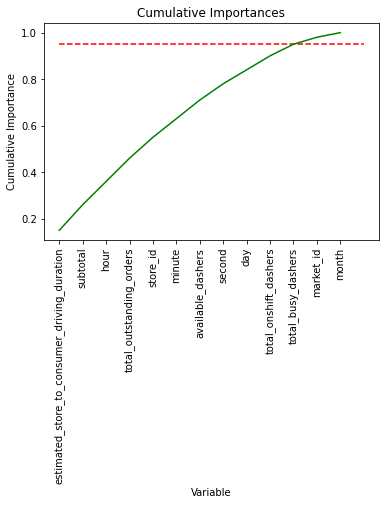

In [ ]:
x_values = list(range(len(importances)))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

# **Training Model with Most Important Features**

In [ ]:
rf_most_important = RandomForestRegressor(n_estimators= 200, random_state=42)

important_feature_names = [feature[0] for feature in feature_importances[0:6]]
feature_list = list(doorDash_ds_baseline.iloc[:, 0:-1].columns)
# Find the columns of the most important features
important_indices = [doorDash_ds_baseline_updated.columns.get_loc(feature) for feature in important_feature_names]

# Extract the two most important features
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]


In [ ]:
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape_important_features = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape_important_features

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 718.24 degrees.
Accuracy: 72.03 %.


# **Saving the Model**

In [ ]:
#Model to use is the tf_exp
joblib.dump(rf_exp, "doordash_random_forest.joblib")

['doordash_random_forest.joblib']

# **Predicting Delivery Time in Seconds for the predict_data file**

In [ ]:
loaded_rf = joblib.load("doordash_random_forest.joblib")

In [ ]:
predictions = loaded_rf.predict(test_features)

In [ ]:
doorDash_ds_pred = pd.read_csv("/content/drive/MyDrive/DoorDash/predict_data.csv")
doorDash_ds_pred.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200


In [ ]:
clean_dataset(doorDash_ds_pred).head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200


In [ ]:
doorDash_ds_pred["available_dashers"]=doorDash_ds_pred["total_onshift_dashers"] - doorDash_ds_pred["total_busy_dashers"]
doorDash_ds_pred["day"] = (pd.to_datetime(pd.Series(doorDash_ds_pred.created_at))).dt.dayofweek
doorDash_ds_pred["year"] = (pd.to_datetime(pd.Series(doorDash_ds_pred.created_at))).dt.year
doorDash_ds_pred["month"] = (pd.to_datetime(pd.Series(doorDash_ds_pred.created_at))).dt.month
doorDash_ds_pred["hour"] = (pd.to_datetime(pd.Series(doorDash_ds_pred.created_at))).dt.hour
doorDash_ds_pred["minute"] = (pd.to_datetime(pd.Series(doorDash_ds_pred.created_at))).dt.minute
doorDash_ds_pred["second"] = (pd.to_datetime(pd.Series(doorDash_ds_pred.created_at))).dt.second

In [ ]:
doorDash_ds_pred_updated = doorDash_ds_pred [["market_id","store_id","month","day","hour","minute","second","total_onshift_dashers", "total_busy_dashers","available_dashers", "subtotal","total_outstanding_orders", "estimated_store_to_consumer_driving_duration"]]

In [ ]:
predictions = loaded_rf.predict(doorDash_ds_pred_updated)

In [ ]:
predicted_df = pd.DataFrame()

predicted_df["delivery_id"] = doorDash_ds_pred["delivery_id"]

predicted_df["predicted_duration"] = predictions

predicted_df.head()

,delivery_id,predicted_duration
0,194096,2701.470
1,236895,3057.830
2,190868,3653.435
3,183076,3114.180
4,186200,2871.550


In [ ]:
predicted_df.to_csv('predictions_for_deliveries.csv') 

# **End**

# **Appendix**


This section refers to all the work that was done in addition to the creating the model but were removed to leave the model clean. 


<br>
<br>


**Adding Randomized Search and Using grid search to find the better model but it too too long and the rf_exp was a better model in terms of accuracy and performance and eventually decided against this**


In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_features, train_labels)

In [ ]:
# Make predictions and determine the error
predictions = rf_random.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape_important_features = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape_important_features

print('Accuracy:', round(accuracy, 2), '%.')

**Tried a nonlinear deep neural network but the loss function was larger than the random forest regression model and so removed it as well**


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

# Hyper-parameters
input_size = 7
output_size = 1
num_epochs = 100
learning_rate = 0.0001

# Toy dataset
x_train = np.array(X_train, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)

x_test = np.array(X_test, dtype=np.float32)

y_test = np.array(y_test, dtype=np.float32)

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

# Linear regression model
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        super(LinearRegression,self).__init__()
        self.layer_1 = nn.Linear(input_size, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, output_size) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self,x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

model = LinearRegression(input_size, output_size)

device = torch.device("cpu")

model.to(device)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

inputs = torch.from_numpy(x_train)
targets = torch.from_numpy(y_train).unsqueeze(-1)
train_ds = TensorDataset(inputs, targets)
batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


test_inputs = torch.from_numpy(x_test)
test_targets = torch.from_numpy(y_test).unsqueeze(-1)
test_ds = TensorDataset(test_inputs, test_targets)

val_loader = DataLoader(dataset=test_ds, batch_size=batch_size)

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
# Train the model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for inputs, targets in train_dl:

    # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      train_acc = multi_acc(outputs, targets)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_epoch_loss += loss.item()
      train_epoch_acc += train_acc.item()

    

    
    #if (epoch+1) % 5 == 0:
    #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    with torch.no_grad():
      val_epoch_loss = 0
      val_epoch_acc = 0
        
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_dl))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dl))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_dl):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_dl):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


# Plot the graph
predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

**Linear regression was the first model I tried and wanted to confirm that a linear model would not work for this dataset because of the non linearity of the dataset**


In [ ]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_train,y_train)

y_prediction =  LR.predict(X_test)
y_prediction

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print("r2 socre is",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_prediction))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_prediction)))

**Tried a multioutput regressor which was also a bad choice**


In [ ]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Create the SVR regressor
svr = SVR(epsilon=0.2)

# Create the Multioutput Regressor
mor = MultiOutputRegressor(svr)

# Train the regressor
mor = mor.fit(X_train, y_train)

# Generate predictions for testing data
y_pred = mor.predict(X_test)

# Evaluate the regressor
mse_one = mean_squared_error(y_test[:,0], y_pred[:,0])
mse_two = mean_squared_error(y_test[:,1], y_pred[:,1])
print(f'MSE for first regressor: {mse_one} - second regressor: {mse_two}')
mae_one = mean_absolute_error(y_test[:,0], y_pred[:,0])
mae_two = mean_absolute_error(y_test[:,1], y_pred[:,1])
print(f'MAE for first regressor: {mae_one} - second regressor: {mae_two}')

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.values.reshape(-1,1))

from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

y_pred = regressor.predict(x_test)
y_pred = sc_y.inverse_transform(y_pred) 

#X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
#X_grid = X_grid.reshape((len(X_), 1))
#plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, y_train, 'ro', label='Original data')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

**Experimented with XGBBoost as well which was also a bad choice**


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train,y_train)

xgb.score(X_test,y_test.reshape(-1, 1))